In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading th CSV File
This csv file was downloaded manually from Google BigQuery. 

In [6]:
file ='../data/external/bq-results-20240527.csv'
df = pd.read_csv(file)
print('DF shape' , df.shape) 
df.head()

DF shape (1021346, 4)


,run_date,month,project,f0_
0,2024-05-27,2024-05-01 00:00:00 UTC,02exercicio,224
1,2024-05-27,2024-05-01 00:00:00 UTC,fs-s3fs,380606
2,2024-05-27,2024-05-01 00:00:00 UTC,eeweather,36525
3,2024-05-27,2024-05-01 00:00:00 UTC,mbtest,11303
4,2024-05-27,2024-05-01 00:00:00 UTC,kanaries-track,31613


## Processing Data

* Grouping the dataset by project and sum the installs
* Adding bins column with logaritmic scale (0,1,100,1000...etc.)

In [7]:
installs = df.groupby('project').agg(installs = ('f0_','sum'))
installs.head()

,installs
project,
0,4274
0-0-1,539
0-618,320
0-core-client,1464
0-mod-butt,1


In [8]:
installs['installs_pct'] = (installs.installs / installs.installs.sum())
bins = [0,1,10,100,1000,10000,100000,1000000,installs.installs.max()]
installs['bin'] = pd.cut(installs.installs,bins = bins)
installs.head()

,installs,installs_pct,bin
project,,,
0,4274,1.076528e-07,"(1000, 10000]"
0-0-1,539,1.357625e-08,"(100, 1000]"
0-618,320,8.060110e-09,"(100, 1000]"
0-core-client,1464,3.687500e-08,"(1000, 10000]"
0-mod-butt,1,2.518784e-11,"(0, 1]"


### Summarizing the dataset
* Grouping the projects by bins 
* Show table with summary stats in each bucket

In [9]:
installs_summary = installs.groupby('bin').agg(projects_count = ('installs','count'),
                                               projects_installs = ('installs','sum'),
                                               projects_installs_pct = ('installs_pct','sum'),

                                               )
installs_summary['projects_installs_pct'] = installs_summary['projects_installs_pct'].apply(lambda x: f'{x:.2%}')
installs_summary

,projects_count,projects_installs,projects_installs_pct
bin,,,
"(0, 1]",11043,11043,0.00%
"(1, 10]",9507,38229,0.00%
"(10, 100]",241675,11623831,0.03%
"(100, 1000]",212489,67274154,0.17%
"(1000, 10000]",49432,144526470,0.36%
"(10000, 100000]",12661,401882649,1.01%
"(100000, 1000000]",4492,1399147950,3.52%
"(1000000, 1388601787]",2058,37677185601,94.90%


### Findings 


This table presents data on projects and their corresponding installation counts categorized into different bins based on the number of installations. Here's a description of the table:

Bin: This column represents the range of installations per project. Each bin range is represented as an interval, such as (0, 1], (1, 10], (10, 100], and so on.

projects_count: This column shows the number of projects falling within each bin range. For instance, there are 11,043 projects in the (0, 1] range, 9,507 projects in the (1, 10] range, and so forth.

projects_installs: This column indicates the number of installations corresponding to the projects within each bin range. For example, there are 11,043 installations in the (0, 1] range, 38,229 installations in the (1, 10] range, and so on.

projects_installs_pct: This column displays the percentage of total installations represented by the projects within each bin range. For instance, projects within the (0, 1] range represent 0.00% of the total installations, projects within the (1, 10] range represent 0.00%, and so forth.



Concentration of Installations:

While most projects fall into the lower installation ranges, a significant portion of the total installations is concentrated in projects with higher installation counts. For instance, projects with over 1,000,000 installations represent 94.90% of the total installations despite being only 2,058 projects.

Long Tail Distribution: The distribution follows a long tail pattern, where a few projects with extremely high installation counts contribute to a large portion of the total installations. Most projects have relatively low installation counts, while a small number have very high installation counts.



### Pareto Analysis

 Pareto Analysis, often referred to as the 80/20 rule or the principle of factor sparsity, is a technique used to prioritize efforts. It states that, for many outcomes, roughly 80% of the consequences come from 20% of the causes. We can apply this analysis to the provided data to identify which installation ranges contribute to most installations.



In [11]:
Pareto = (installs
 .sort_values(by = 'installs',ascending = False)
 .reset_index()
 .installs_pct
 .cumsum()
 )
Pareto.index = Pareto.index/ Pareto.count()

In [ ]:
## remove trailing zeros from string 
def remove_trailing_zeros(s):
    l = list(s)
    if  l[-2] == '0':
        del l[-2]
        s = ''.join(l)
    else:
        return s
        
    return remove_trailing_zeros(s)
### remove dot if there's no decimal values
def remove_dot(s):

    l = list(s)
    if  l[-2] == '.':
        del l[-2]
        s = ''.join(l)
    
    return s


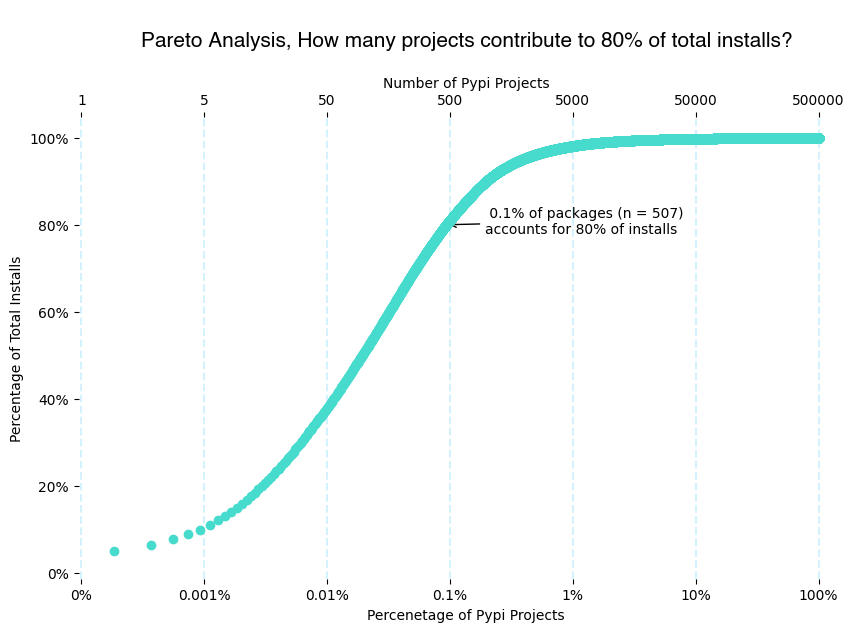

In [242]:
fig, ax = plt.subplots(figsize=(10, 6))

hfont = {'fontname':'Helvetica', 'fontweight':'bold','fontsize':15}


# Step 6: Plot the cumulative sum of the percentages with a logarithmic x-axis
ax.plot(Pareto.index, Pareto, color = 'white' , linewidth = 3,marker = 'o',alpha = 0) 
ax.set_xlabel('Percenetage of Pypi Projects')
ax.set_ylabel('Percentage of Total Installs')
ax.set_title('\nPareto Analysis, How many projects contribute to 80% of total installs?\n',**hfont)
ax.set_xscale('log')
ax.set_yticklabels([f'{i:.0%}'for i in ax.get_yticks()]);
ax.set_xticklabels([remove_dot(remove_trailing_zeros(str(f'{i:.3%}'))) for  i in ax.get_xticks()])

idx_80 = Pareto[Pareto <= .8].idxmax() 


text = f' {idx_80:.1%} of packages (n = {idx_80 * Pareto.count():.0f})\naccounts for 80% of installs'

ax.annotate(text, xy=(idx_80, .8), xytext=(idx_80 + 0.001, .78),
             arrowprops=dict(facecolor='red',arrowstyle = '->'), fontsize=10, color='black')


ax2_l = {}
for x in ax.get_xticks():
    c = x * 100000
    y = round(round((Pareto.count()) * x )//c * c )
    if y >= 1 and x <= 1 :
      ax2_l[x] = y
      ax.axvline(x, color='#2CBDFE', alpha=0.2, linestyle='--')
    

ax2 = ax.twiny()
ax2.set_xlabel('Number of Pypi Projects')
ax2.plot(Pareto.index, Pareto, color = '#47DBCD' , linewidth = 3, marker = 'o', linestyle='None')
ax2.set_xscale('log')
ax2.set_xticks([*ax2_l.keys()], labels = [*ax2_l.values()])
# change background color
ax.set_facecolor('white')
ax.minorticks_off()
ax2.minorticks_off()

# remove axis 
ax.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)

#change fig color 



In [243]:
installs.sort_values(by = 'installs_pct',ascending = False).head(50)

,installs,installs_pct,bin
project,,,
boto3,1388601787,0.034976,"(1000000, 1388601787]"
botocore,645035046,0.016247,"(1000000, 1388601787]"
urllib3,533921148,0.013448,"(1000000, 1388601787]"
requests,485817094,0.012237,"(1000000, 1388601787]"
wheel,474966050,0.011963,"(1000000, 1388601787]"
certifi,422973123,0.010654,"(1000000, 1388601787]"
idna,417220064,0.010509,"(1000000, 1388601787]"
typing-extensions,417080677,0.010505,"(1000000, 1388601787]"
charset-normalizer,411354621,0.010361,"(1000000, 1388601787]"


### How many packages you know ? how many of them only installed because they were dependencies? 